In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"negarmansouri96","key":"dff6cfe0d2006e749b7c718a13c89eef"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d mkashifn/nbaiot-dataset

Dataset URL: https://www.kaggle.com/datasets/mkashifn/nbaiot-dataset
License(s): unknown
 99% 1.74G/1.75G [00:21<00:00, 95.7MB/s]
100% 1.75G/1.75G [00:21<00:00, 85.7MB/s]


In [5]:
import zipfile
import os
zip_file_path = "/content/nbaiot-dataset.zip"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

os.remove("/content/extracted_files/README.md")
os.remove("/content/extracted_files/data_summary.csv")
os.remove("/content/extracted_files/device_info.csv")
os.remove("/content/extracted_files/features.csv")


In [6]:
import re
import pandas as pd

csv_files = [f for f in os.listdir('extracted_files') if f.endswith('.csv')]

n_bootstrap_samples = 13000

bootstrapped_dfs = []

def clean_label(file_name):
    return re.sub(r'^\d+\.', '', file_name)

for file in csv_files:
    df = pd.read_csv(os.path.join('extracted_files', file))

    bootstrap_sample = df.sample(n=n_bootstrap_samples, replace=False, random_state=42)

    label = clean_label(file.replace('.csv', ''))

    bootstrap_sample['label'] = label


    bootstrapped_dfs.append(bootstrap_sample)

final_df = pd.concat(bootstrapped_dfs, ignore_index=True)

print(final_df.head())

category_counts = final_df['label'].value_counts()
print("\nCategory Counts:")
print(category_counts)



   MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
0               1.0            60.0                 0.0               1.0   
1               1.0            60.0                 0.0               1.0   
2               1.0            60.0                 0.0               1.0   
3               1.0            60.0                 0.0               1.0   
4               1.0            60.0                 0.0               1.0   

   MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
0            60.0                 0.0               1.0            60.0   
1            60.0                 0.0               1.0            60.0   
2            60.0                 0.0               1.0            60.0   
3            60.0                 0.0               1.0            60.0   
4            60.0                 0.0               1.0            60.0   

   MI_dir_L1_variance  MI_dir_L0.1_weight  ...  HpHp_L0.1_covariance  \
0             

In [7]:
print(final_df.describe())

       MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  MI_dir_L3_weight  \
count      1.157000e+06    1.157000e+06        1.157000e+06      1.157000e+06   
mean       8.267593e+01    1.496655e+02        1.109874e+04      1.303857e+02   
std        6.978007e+01    1.466430e+02        2.141066e+04      1.117528e+02   
min        1.000000e+00    6.000000e+01        0.000000e+00      1.000000e+00   
25%        1.032211e+00    6.000001e+01        2.728484e-12      1.142845e+00   
50%        8.403074e+01    7.402638e+01        1.966007e+00      1.241315e+02   
75%        1.479464e+02    1.900609e+02        5.430793e+03      2.389061e+02   
max        4.380028e+02    1.452096e+03        4.712302e+05      5.586770e+02   

       MI_dir_L3_mean  MI_dir_L3_variance  MI_dir_L1_weight  MI_dir_L1_mean  \
count    1.157000e+06        1.157000e+06      1.157000e+06    1.157000e+06   
mean     1.497768e+02        1.234093e+04      3.662275e+02    1.501464e+02   
std      1.423662e+02        2.25

In [8]:
print("Unique values in the 'label' column:", final_df['label'].unique())


Unique values in the 'label' column: ['gafgyt.tcp' 'gafgyt.combo' 'gafgyt.junk' 'mirai.syn' 'gafgyt.scan'
 'mirai.udpplain' 'benign' 'gafgyt.udp' 'mirai.udp' 'mirai.scan'
 'mirai.ack']


In [9]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
import pandas as pd

features = final_df.drop(columns=['label'])
labels = final_df['label']

label_encoder = LabelEncoder()

encoded_labels = label_encoder.fit_transform(labels)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

n_estimators = 100
rf = RandomForestClassifier(n_estimators=1, warm_start=True, random_state=42, n_jobs=-1)

for i in tqdm(range(1, n_estimators + 1), desc="Building Trees"):
    rf.set_params(n_estimators=i)
    rf.fit(scaled_features, encoded_labels)

importances = rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': features.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top_27_features = feature_importance_df.head(27)['Feature'].values
print("Top 27 selected features:")
print(top_27_features)

selected_features_df = final_df[top_27_features]

final_data = pd.concat([selected_features_df, pd.DataFrame(encoded_labels, columns=['encoded_label'])], axis=1)

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

print(final_data.head())


Building Trees: 100%|██████████| 100/100 [08:37<00:00,  5.18s/it]


Top 27 selected features:
['H_L0.01_mean' 'MI_dir_L0.1_weight' 'MI_dir_L0.01_mean' 'H_L0.1_weight'
 'H_L0.01_variance' 'H_L0.01_weight' 'MI_dir_L0.01_variance' 'H_L1_mean'
 'HH_L0.1_magnitude' 'MI_dir_L0.1_variance' 'MI_dir_L0.1_mean'
 'MI_dir_L0.01_weight' 'H_L0.1_mean' 'H_L0.1_variance' 'H_L1_weight'
 'HH_L0.01_magnitude' 'HH_jit_L0.01_mean' 'MI_dir_L1_mean'
 'HH_jit_L3_mean' 'HH_jit_L0.1_mean' 'MI_dir_L1_weight' 'HH_jit_L1_mean'
 'MI_dir_L3_weight' 'HH_L3_weight' 'H_L3_weight' 'HH_jit_L0.01_weight'
 'HH_jit_L5_mean']
Label Mapping: {'benign': 0, 'gafgyt.combo': 1, 'gafgyt.junk': 2, 'gafgyt.scan': 3, 'gafgyt.tcp': 4, 'gafgyt.udp': 5, 'mirai.ack': 6, 'mirai.scan': 7, 'mirai.syn': 8, 'mirai.udp': 9, 'mirai.udpplain': 10}
   H_L0.01_mean  MI_dir_L0.1_weight  MI_dir_L0.01_mean  H_L0.1_weight  \
0          60.0                 1.0               60.0            1.0   
1          60.0                 1.0               60.0            1.0   
2          60.0                 1.0               

In [10]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

features = final_data.iloc[:, :-1]
labels = final_data['encoded_label']

scaler = MinMaxScaler(feature_range=(0, 255))
scaled_features = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=9, random_state=42)
kmeans.fit(scaled_features.T)

cluster_assignments = kmeans.labels_

image_dataset = []
image_labels = []

for i in range(scaled_features.shape[0]):
    feature_row = scaled_features[i, :]
    rgb_image = np.zeros((3, 3, 3))


    for cluster_idx in range(9):
        feature_indices = np.where(cluster_assignments == cluster_idx)[0]


        for channel, feature_index in enumerate(feature_indices[:3]):
            x = cluster_idx // 3  # Row index in 3x3 grid
            y = cluster_idx % 3   # Column index in 3x3 grid
            rgb_image[x, y, channel] = feature_row[feature_index]

    image_dataset.append(rgb_image)
    image_labels.append(labels.iloc[i])

image_dataset = np.array(image_dataset)
image_labels = np.array(image_labels)

print(f"Image dataset shape: {image_dataset.shape}")
print(f"Label dataset shape: {image_labels.shape}")


Image dataset shape: (1157000, 3, 3, 3)
Label dataset shape: (1157000,)


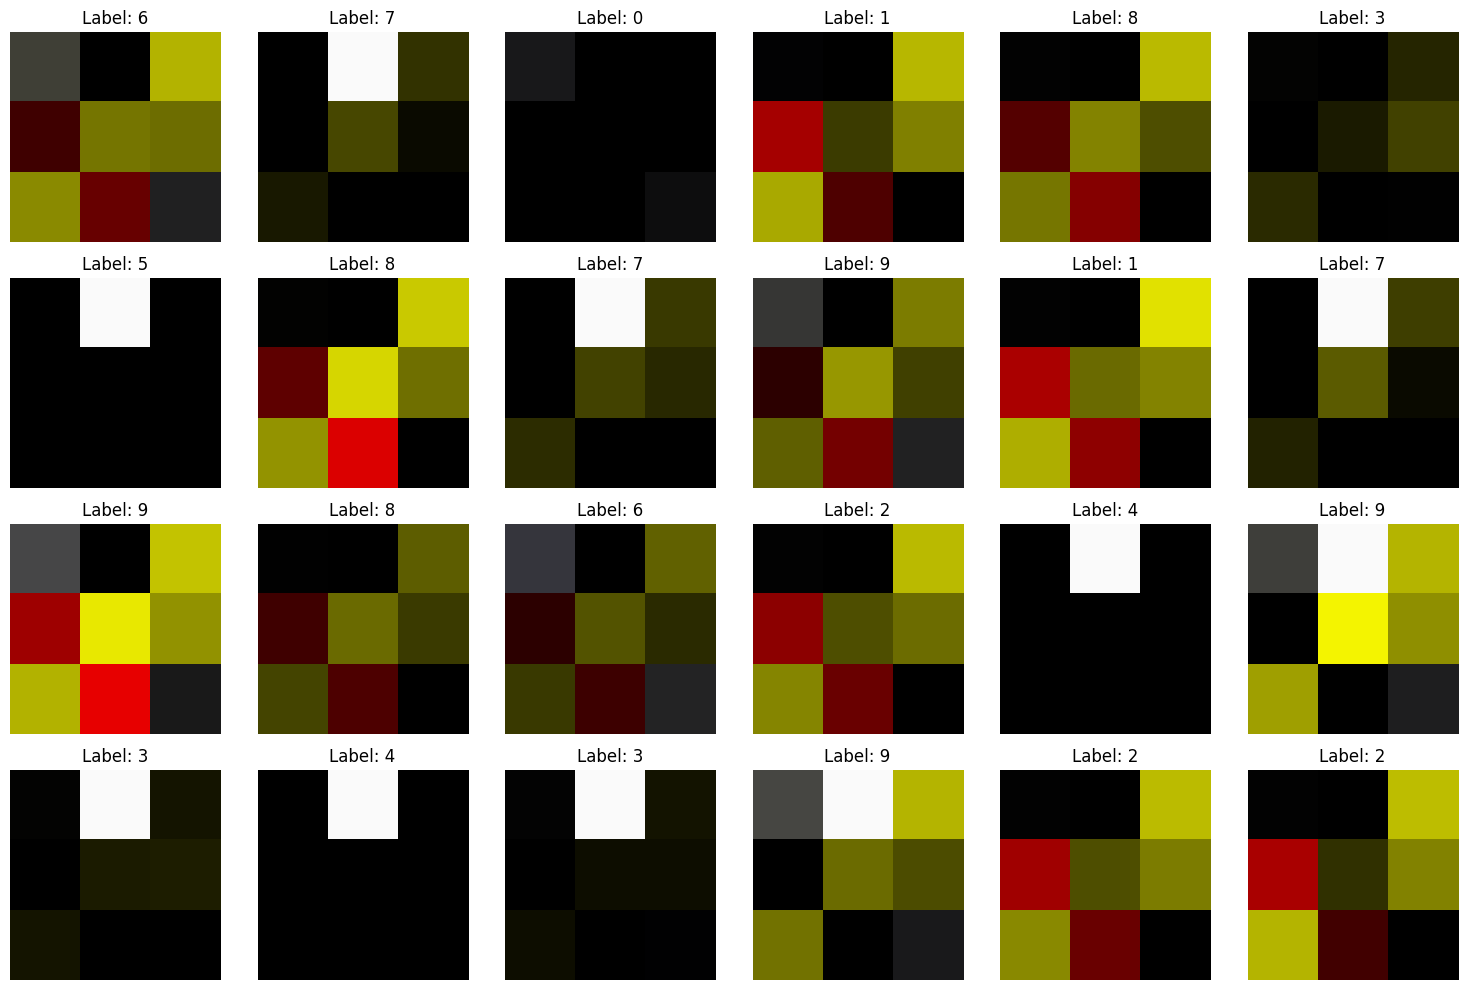

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def show_random_images(image_dataset, image_labels, num_samples=24):
    indices = np.random.choice(len(image_dataset), num_samples, replace=False)
    selected_images = image_dataset[indices]
    selected_labels = image_labels[indices]

    fig, axes = plt.subplots(4, 6, figsize=(15, 10))

    axes = axes.flatten()

    for i in range(num_samples):
        img = selected_images[i]
        label = selected_labels[i]

        axes[i].imshow(img.astype(np.uint8))  # Convert to uint8 for display
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')

    for j in range(num_samples, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

show_random_images(image_dataset, image_labels)


Using device: cuda
AutoencoderCNN(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): AdaptiveAvgPool2d(output_size=1)
  )
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=11, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=64, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

Training Epochs:   5%|▌         | 1/20 [01:59<37:47, 119.33s/it]

Epoch [1/20], Loss: 7585.7662, Classification Loss: 0.4179, Reconstruction Loss: 7585.3484, Accuracy: 78.24%


Training Epochs:  10%|█         | 2/20 [03:55<35:15, 117.55s/it]

Epoch [2/20], Loss: 7585.0691, Classification Loss: 0.2162, Reconstruction Loss: 7584.8529, Accuracy: 86.77%


Training Epochs:  15%|█▌        | 3/20 [05:51<33:04, 116.74s/it]

Epoch [3/20], Loss: 7585.0117, Classification Loss: 0.1721, Reconstruction Loss: 7584.8397, Accuracy: 88.30%


Training Epochs:  20%|██        | 4/20 [07:48<31:08, 116.79s/it]

Epoch [4/20], Loss: 7585.0402, Classification Loss: 0.1608, Reconstruction Loss: 7584.8795, Accuracy: 88.81%


Training Epochs:  25%|██▌       | 5/20 [09:34<28:15, 113.04s/it]

Epoch [5/20], Loss: 7585.0359, Classification Loss: 0.1541, Reconstruction Loss: 7584.8819, Accuracy: 88.99%


Training Epochs:  30%|███       | 6/20 [11:16<25:30, 109.32s/it]

Epoch [6/20], Loss: 7584.9912, Classification Loss: 0.1511, Reconstruction Loss: 7584.8402, Accuracy: 89.07%


Training Epochs:  35%|███▌      | 7/20 [13:10<23:58, 110.69s/it]

Epoch [7/20], Loss: 7585.0173, Classification Loss: 0.1469, Reconstruction Loss: 7584.8704, Accuracy: 89.24%


Training Epochs:  40%|████      | 8/20 [15:05<22:25, 112.09s/it]

Epoch [8/20], Loss: 7584.9170, Classification Loss: 0.1447, Reconstruction Loss: 7584.7722, Accuracy: 89.28%


Training Epochs:  45%|████▌     | 9/20 [16:57<20:33, 112.16s/it]

Epoch [9/20], Loss: 7584.9480, Classification Loss: 0.1443, Reconstruction Loss: 7584.8036, Accuracy: 89.31%


Training Epochs:  50%|█████     | 10/20 [18:48<18:38, 111.82s/it]

Epoch [10/20], Loss: 7584.9537, Classification Loss: 0.1414, Reconstruction Loss: 7584.8123, Accuracy: 89.41%


Training Epochs:  55%|█████▌    | 11/20 [20:41<16:48, 112.03s/it]

Epoch [11/20], Loss: 7584.9498, Classification Loss: 0.1393, Reconstruction Loss: 7584.8105, Accuracy: 89.46%


Training Epochs:  60%|██████    | 12/20 [22:37<15:05, 113.21s/it]

Epoch [12/20], Loss: 7584.9365, Classification Loss: 0.1370, Reconstruction Loss: 7584.7995, Accuracy: 89.54%


Training Epochs:  65%|██████▌   | 13/20 [24:32<13:16, 113.77s/it]

Epoch [13/20], Loss: 7584.9082, Classification Loss: 0.1348, Reconstruction Loss: 7584.7734, Accuracy: 89.62%


Training Epochs:  70%|███████   | 14/20 [26:26<11:23, 113.89s/it]

Epoch [14/20], Loss: 7584.9237, Classification Loss: 0.1326, Reconstruction Loss: 7584.7911, Accuracy: 89.70%


Training Epochs:  75%|███████▌  | 15/20 [28:20<09:29, 113.84s/it]

Epoch [15/20], Loss: 7584.9016, Classification Loss: 0.1308, Reconstruction Loss: 7584.7708, Accuracy: 89.71%


Training Epochs:  80%|████████  | 16/20 [30:03<07:22, 110.61s/it]

Epoch [16/20], Loss: 7584.9041, Classification Loss: 0.1297, Reconstruction Loss: 7584.7744, Accuracy: 89.83%


Training Epochs:  85%|████████▌ | 17/20 [31:36<05:16, 105.42s/it]

Epoch [17/20], Loss: 7584.8979, Classification Loss: 0.1286, Reconstruction Loss: 7584.7693, Accuracy: 89.84%


Training Epochs:  90%|█████████ | 18/20 [33:19<03:29, 104.70s/it]

Epoch [18/20], Loss: 7584.9195, Classification Loss: 0.1279, Reconstruction Loss: 7584.7916, Accuracy: 89.86%


Training Epochs:  95%|█████████▌| 19/20 [35:14<01:47, 107.82s/it]

Epoch [19/20], Loss: 7584.9374, Classification Loss: 0.1275, Reconstruction Loss: 7584.8099, Accuracy: 89.81%


Training Epochs: 100%|██████████| 20/20 [37:09<00:00, 111.48s/it]

Epoch [20/20], Loss: 7584.8988, Classification Loss: 0.1273, Reconstruction Loss: 7584.7715, Accuracy: 89.87%



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([40, 3, 3, 3])) that is different to the input size (torch.Size([40, 3, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss: 7598.1212, Test Accuracy: 89.89%


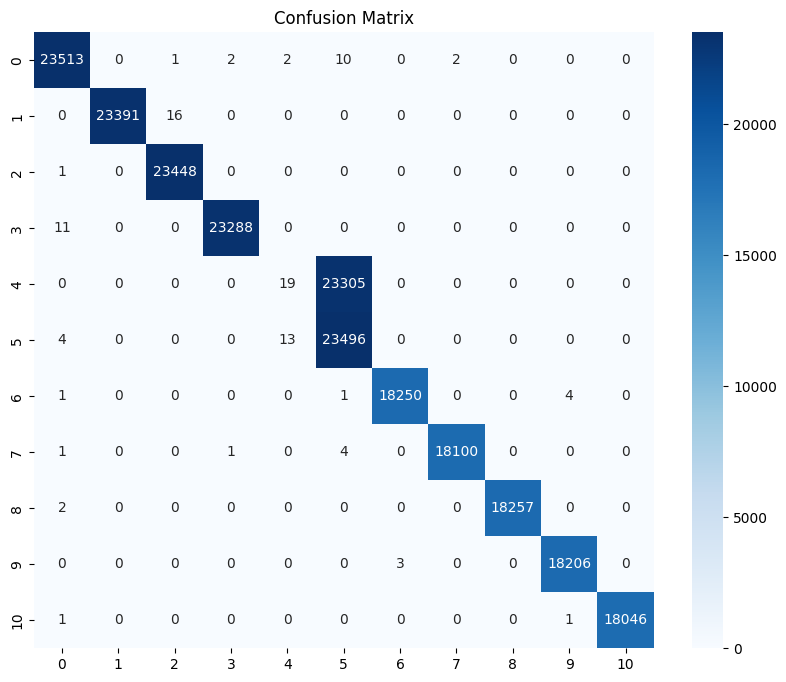

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23530
           1       1.00      1.00      1.00     23407
           2       1.00      1.00      1.00     23449
           3       1.00      1.00      1.00     23299
           4       0.56      0.00      0.00     23324
           5       0.50      1.00      0.67     23513
           6       1.00      1.00      1.00     18256
           7       1.00      1.00      1.00     18106
           8       1.00      1.00      1.00     18259
           9       1.00      1.00      1.00     18209
          10       1.00      1.00      1.00     18048

    accuracy                           0.90    231400
   macro avg       0.91      0.91      0.88    231400
weighted avg       0.90      0.90      0.87    231400



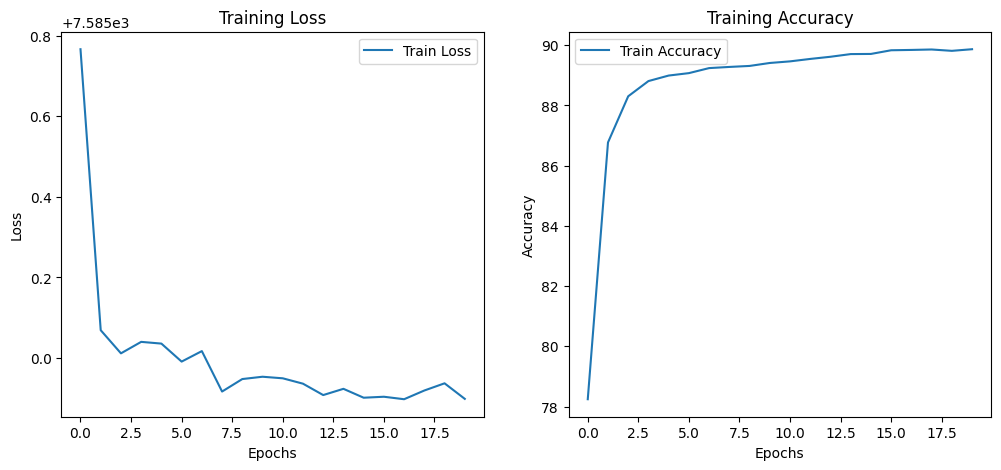

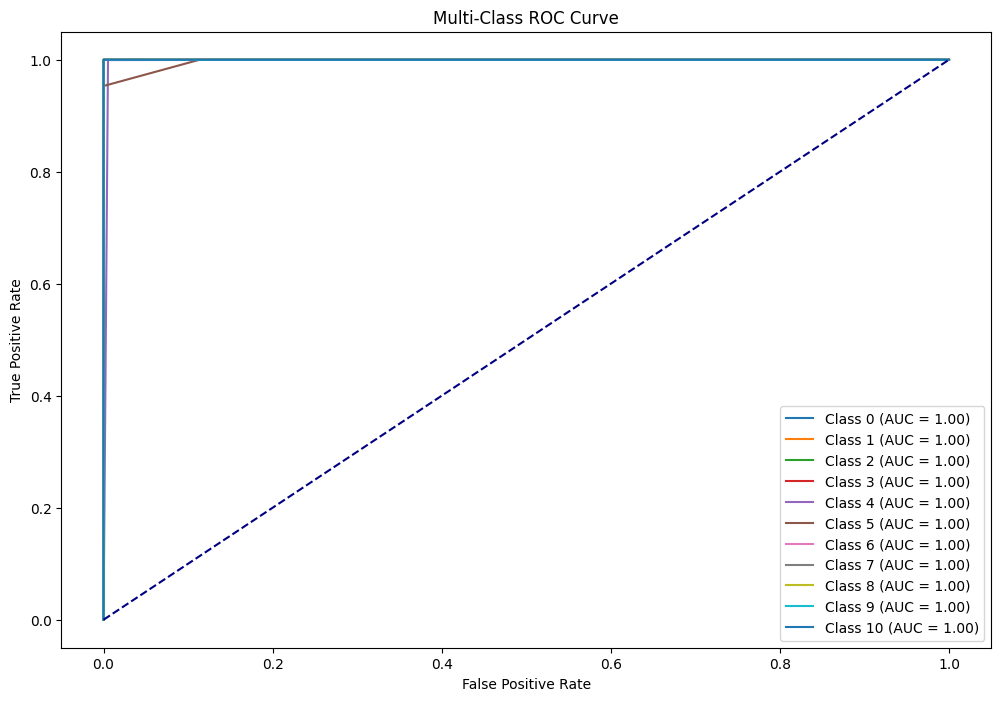

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
from tqdm import tqdm

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Prepare the dataset
image_dataset_tensor = torch.tensor(image_dataset, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, C, H, W)
image_labels_tensor = torch.tensor(image_labels, dtype=torch.long)

# Compute class weights for imbalance handling
class_counts = torch.bincount(image_labels_tensor)
class_weights = 1.0 / class_counts
weights = class_weights.to(device)

# Dataset splitting
dataset = TensorDataset(image_dataset_tensor, image_labels_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define Autoencoder architecture
class AutoencoderCNN(nn.Module):
    def __init__(self, num_classes):
        super(AutoencoderCNN, self).__init__()

        # Encoder: Compress the 3x3x3 input image into a latent space
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),  # (3, 3, 3) -> (16, 3, 3)
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  # (16, 3, 3) -> (32, 3, 3)
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # (32, 3, 3) -> (64, 3, 3)
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.AdaptiveAvgPool2d(1),  # (64, 3, 3) -> (64, 1, 1)
        )

        # Latent space (dense layer)
        self.fc1 = nn.Linear(64, 128)  # (64) -> (128)
        self.fc2 = nn.Linear(128, num_classes)  # (128) -> (num_classes)

        # Decoder: Reconstruct the image from the latent space
        self.fc3 = nn.Linear(128, 64)  # (128) -> (64)
        self.fc4 = nn.Linear(64, 64 * 1 * 1)  # (64) -> (64, 1, 1)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),  # (64, 1, 1) -> (32, 3, 3)
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),  # (32, 3, 3) -> (16, 3, 3)
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1),  # (16, 3, 3) -> (3, 3, 3)
            nn.Sigmoid(),  # Output should be in range [0, 1] (reconstruction)
        )

    def forward(self, x):
        # Encoding
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten for the fully connected layer
        x = self.fc1(x)
        class_output = self.fc2(x)  # Classification output

        # Decoding (Reconstruction)
        x = self.fc3(x)
        x = self.fc4(x)
        x = x.view(x.size(0), 64, 1, 1)  # Reshape back for ConvTranspose2d
        reconstruction_output = self.decoder(x)

        return class_output, reconstruction_output

# Instantiate the model, loss function, optimizer, and scheduler
num_classes = len(torch.unique(image_labels_tensor))
model = AutoencoderCNN(num_classes=num_classes).to(device)

# Loss function for both classification and reconstruction
classification_criterion = nn.CrossEntropyLoss(weight=weights)
reconstruction_criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# Function to count and print the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print model architecture
print(model)
print(f"Number of trainable parameters: {count_parameters(model)}")

# Early Stopping class
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Train the model
def train_model(model, train_loader, criterion_class, criterion_recon, optimizer, scheduler, num_epochs=20):
    train_losses = []
    train_accuracies = []

    for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
        model.train()
        running_loss = 0.0
        running_class_loss = 0.0
        running_recon_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            class_output, reconstruction_output = model(images)

            # Classification loss
            class_loss = criterion_class(class_output, labels)

            # Reconstruction loss
            recon_loss = criterion_recon(reconstruction_output, images)

            # Total loss is the sum of both losses
            loss = class_loss + recon_loss

            # Backpropagation
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_class_loss += class_loss.item()
            running_recon_loss += recon_loss.item()

            # Classification accuracy
            _, predicted = class_output.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_class_loss = running_class_loss / len(train_loader)
        epoch_recon_loss = running_recon_loss / len(train_loader)
        epoch_accuracy = 100. * correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Update learning rate and check for early stopping
        scheduler.step()
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, "
              f"Classification Loss: {epoch_class_loss:.4f}, "
              f"Reconstruction Loss: {epoch_recon_loss:.4f}, "
              f"Accuracy: {epoch_accuracy:.2f}%")

    return train_losses, train_accuracies

# Evaluate the model and generate confusion matrix
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            class_output, reconstruction_output = model(images)
            class_loss = classification_criterion(class_output, labels)
            recon_loss = reconstruction_criterion(reconstruction_output, images)
            loss = class_loss + recon_loss

            test_loss += loss.item()

            _, predicted = class_output.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100. * correct / total
    test_loss = test_loss / len(test_loader)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

    # Precision, Recall, F1-Score
    report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(num_classes)])
    print(report)

    return test_loss, accuracy

# ROC and AUC curves for multi-class classification
def plot_multi_class_roc(model, test_loader, num_classes):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            class_output, _ = model(images)
            probs = nn.functional.softmax(class_output, dim=1)
            all_preds.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Binarize the labels for multi-class ROC curve calculation
    all_labels_binarized = label_binarize(all_labels, classes=list(range(num_classes)))

    plt.figure(figsize=(12, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(all_labels_binarized[:, i], all_preds[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

# Train the model
num_epochs = 20
early_stopping = EarlyStopping(patience=5, delta=0.001)
train_losses, train_accuracies = train_model(model, train_loader, classification_criterion, reconstruction_criterion, optimizer, scheduler, num_epochs)

# Evaluate the model
test_loss, test_accuracy = evaluate_model(model, test_loader)

# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Plot ROC-AUC curves
plot_multi_class_roc(model, test_loader, num_classes)
